#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 07
**CH07A Finding a Good Deal among Hotels with Simple Regression**

hotels-vienna  dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:

# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]
 
# location folders
data_in = dirname + "da_data_repo/hotels-vienna/clean/"
data_out = dirname + "da_case_studies/ch03-hotels-vienna-explore/"
output = dirname + "da_case_studies/ch03-hotels-vienna-explore/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
import py_helper_functions as da
sns.set_theme(rc=da.da_theme, palette=da.color)


In [4]:
# load vienna
hotels = pd.read_csv(data_in + "hotels-vienna.csv")
# hotels = pd.read_csv("https://osf.io/y6jvb/download")
 

### SAMPLE SELECTION

Apply filters:  3-4 stars, Vienna actual, without  extreme value

In [5]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]


In [6]:
# save a copy of the work file
hotels.to_csv(data_out + "hotels_work.csv", index=False)


### Summary statistics on price and distance

In [7]:
# Price
hotels[["price"]].describe(percentiles=[0.50, 0.95])


,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


In [8]:
# Distance
hotels[["distance"]].describe(percentiles=[0.50, 0.95])


,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
50%,1.300000
95%,3.900000
max,6.600000


### REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE


In [9]:
hotels["dist2"] = hotels["distance"] >= 2

In [10]:
hotels["Eprice_cat2"] = hotels.groupby("dist2")["price"].transform("mean")

In [11]:
hotels["dist2"] = hotels["dist2"].replace(0, "Close")
hotels["dist2"] = hotels["dist2"].replace(1, "Far")

In [12]:
hotels[["dist2", "distance", "price"]].groupby("dist2").aggregate("describe")

distance                                               price  \
         count      mean       std  min  25%  50%  75%  max  count   
dist2                                                                
False    157.0  0.994904  0.539325  0.0  0.5  0.9  1.5  1.9  157.0   
True      50.0  3.210000  0.973789  2.0  2.4  3.1  3.7  6.6   50.0   

                                                                
             mean        std   min    25%    50%    75%    max  
dist2                                                           
False  116.426752  43.095928  54.0  85.00  109.0  135.0  383.0  
True    89.720000  32.085371  50.0  74.25   81.5   96.5  208.0

# Figure 7.1a
# PLOT MEAN VALUES BY CLOSE VS FAR

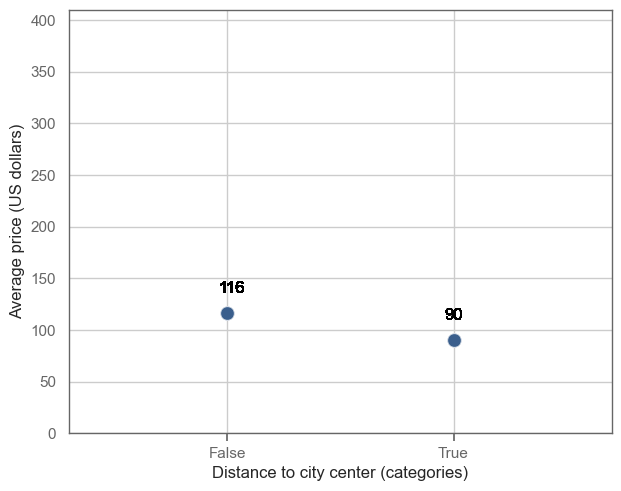

In [13]:
sns.scatterplot(
    data=hotels,
    x='dist2',
    y='Eprice_cat2',
    s=100,  
    color=da.color[0],
    alpha=0.4
)


for idx, row in hotels.iterrows():
    plt.text(
        row['dist2'] - 0.04, 
        row['Eprice_cat2'] + 20,  
        str(int(round(row['Eprice_cat2']))),  
        color='black',
        fontsize=12 
    )

plt.xlabel("Distance to city center (categories)", fontsize=12)
plt.ylabel("Average price (US dollars)", fontsize=12)
plt.xlim(-0.7, 1.7)
plt.xticks([False, True], labels=["False", "True"])  
plt.ylim(0, 410)
plt.yticks(np.arange(0, 401, 50))


plt.show()

In [14]:
hotels["dist4"] = hotels["distance"].apply(
    lambda x: 0.5 + 1 * int(x >= 1) + 1 * int(x >= 2) + 2.5 * int(x >= 3)
)
hotels["Eprice_cat4"] = hotels.groupby("dist4")["price"].transform("mean")

In [15]:
hotels[["dist4", "distance", "price"]].groupby("dist4").aggregate("describe")


distance                                                price  \
         count      mean       std  min    25%  50%  75%  max count   
dist4                                                                 
0.5       81.0  0.554321  0.282865  0.0  0.300  0.6  0.8  0.9  81.0   
1.5       76.0  1.464474  0.294258  1.0  1.200  1.5  1.7  1.9  76.0   
2.5       22.0  2.354545  0.318818  2.0  2.100  2.3  2.6  2.9  22.0   
5.0       28.0  3.882143  0.759656  3.0  3.475  3.7  4.1  6.6  28.0   

                                                                  
             mean        std   min     25%    50%     75%    max  
dist4                                                             
0.5    132.913580  38.540627  68.0  110.00  128.0  152.00  242.0  
1.5     98.855263  40.893261  54.0   81.75   91.5  105.25  383.0  
2.5     97.545455  40.385909  54.0   76.25   82.5  100.75  208.0  
5.0     83.571429  22.596998  50.0   68.75   79.0   91.25  156.0

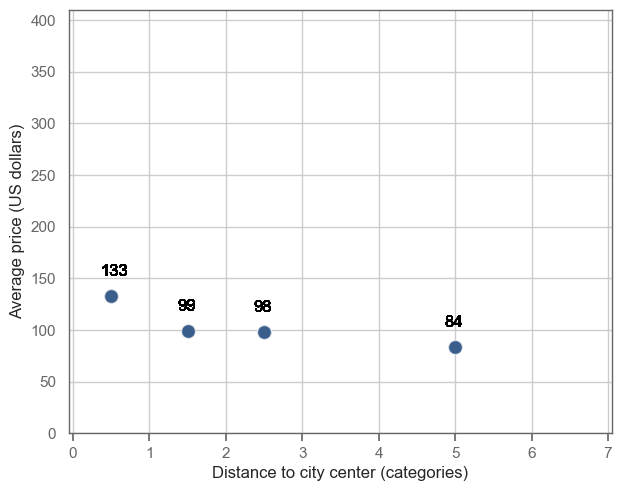

In [16]:
sns.scatterplot(
    data=hotels,
    x='dist4',
    y='Eprice_cat4',
    s=100,  
    color=da.color[0],
    alpha=0.4
)


for idx, row in hotels.iterrows():
    plt.text(
        row['dist4'] - 0.14, 
        row['Eprice_cat4'] + 20,  
        str(int(round(row['Eprice_cat4']))),  
        color='black',
        fontsize=12 
    )

plt.xlabel("Distance to city center (categories)", fontsize=12)
plt.ylabel("Average price (US dollars)", fontsize=12)
plt.xlim(-0.05, 7.05) 
plt.ylim(0, 410)
plt.yticks(np.arange(0, 401, 50))


plt.show()

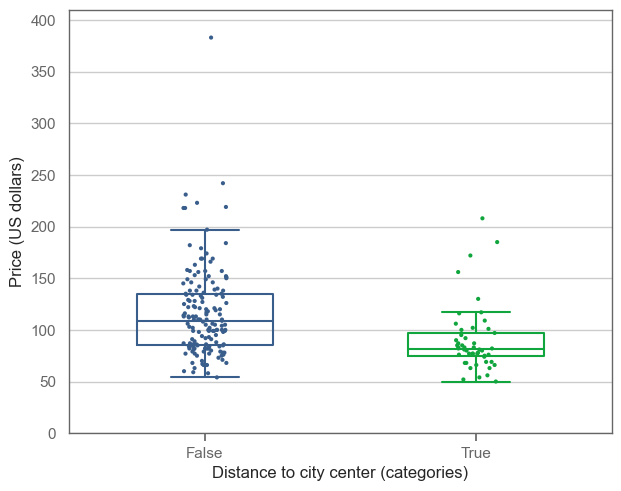

In [17]:
fig, ax = plt.subplots()
sns.boxplot(
    data=hotels,
    x='dist2',
    y='price',
    width=0.5,
    showfliers=False,  
    fill = False
)

for i in range(0,int(len(ax.lines)/2)):
    ax.lines[i].set_color(da.color[0])

for i in range(int(len(ax.lines)/2),len(ax.lines)):
    ax.lines[i].set_color(da.color[1])

sns.stripplot(
    data=hotels,
    x='dist2',
    y='price',
    palette=da.color,  
    size=3,  
    alpha=1,
    jitter=0.08
)

plt.xlabel("Distance to city center (categories)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.ylim(0, 410)
plt.yticks(np.arange(0, 401, 50))
plt.xticks([0, 1], labels=["False", "True"])  
plt.show()


## FIGURE 7.2a 7.2b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


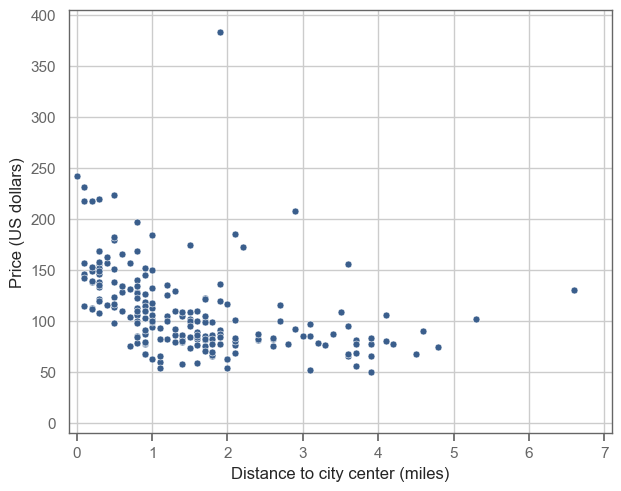

In [18]:
sns.scatterplot(
    data=hotels,
    x='distance',
    y='price',
    color=da.color[0],
    alpha=1,
    s=25
)

# Customize axes
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


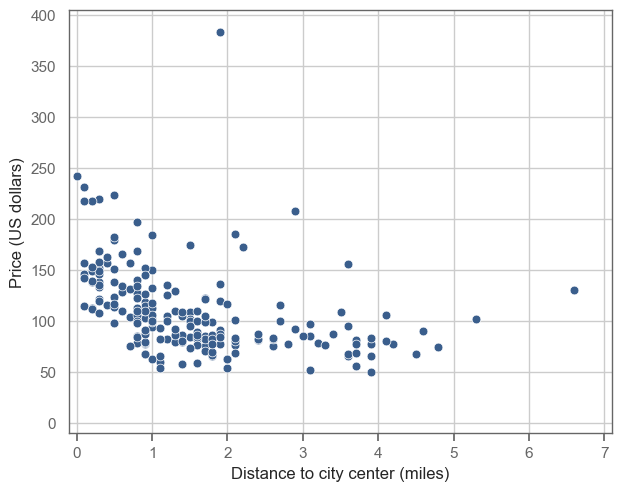

In [19]:
sns.scatterplot(
    data=hotels,
    x='distance',
    y='price',
    color=da.color[0],
    alpha=1,
    s=40
)


plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  
plt.legend().remove()
plt.show()

#### Scatterplot with step function (we use 1km bits for simpplicity using 4 bits for 3-7km)


In [20]:
hotels["dist4_s"] = hotels["distance"].apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
)
hotels["xend"] = hotels["dist4_s"] + 1
hotels["yend"] = hotels["Eprice_cat4"]


In [21]:
hotels["xend"].value_counts()

xend
1    81
2    76
3    22
4    20
5     6
6     1
7     1
Name: count, dtype: int64

In [22]:
hotels["yend"].value_counts()

yend
132.913580    81
98.855263     76
83.571429     28
97.545455     22
Name: count, dtype: int64

In [23]:
hotels[["dist4_s","xend","yend"]]

,dist4_s,xend,yend
1,1,2,98.855263
2,1,2,98.855263
3,1,2,98.855263
4,1,2,98.855263
6,0,1,132.913580
...,...,...,...
420,1,2,98.855263
421,1,2,98.855263
422,1,2,98.855263
425,1,2,98.855263


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


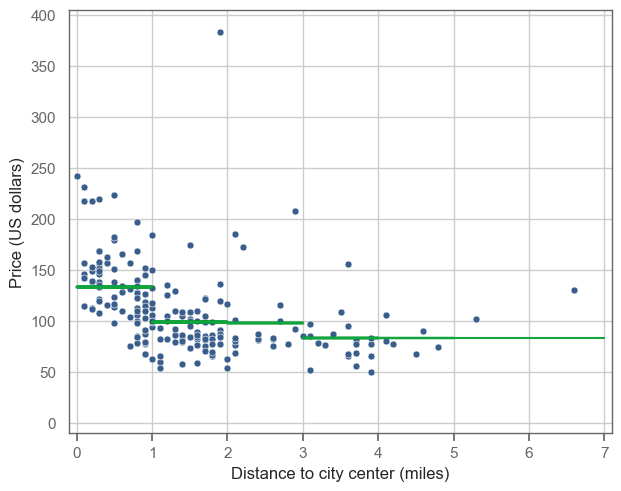

In [24]:
sns.scatterplot(
    data=hotels,
    x='distance',
    y='price',
    color=da.color[0],
    alpha=1,
    s=25
)
for _, row in hotels.iterrows():
    plt.plot([row["dist4_s"],row["xend"]],
             [row["yend"],row["yend"]],linewidth = 1.5,color = da.color[1])
# Customize axes
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

In [25]:
hotels["dist7_new"] = hotels["distance"].apply(
    lambda x: 0.5
    + 1 * int(x + 1 >= 1)
    + 1 * int(x + 1 >= 2)
    + 1 * int(x + 1 >= 3)
    + 1 * int(x + 1 >= 4)
    + 1 * int(x + 1 >= 5)
    + 1 * int(x + 1 >= 6)
    + 1 * int(x + 1 >= 7)
)


In [26]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

In [27]:
hotels[["dist7_new", "distance", "price"]].groupby("dist7_new").aggregate("describe")


distance                                                   price  \
             count      mean       std  min    25%   50%    75%  max count   
dist7_new                                                                    
1.5           81.0  0.554321  0.282865  0.0  0.300  0.60  0.800  0.9  81.0   
2.5           76.0  1.464474  0.294258  1.0  1.200  1.50  1.700  1.9  76.0   
3.5           22.0  2.354545  0.318818  2.0  2.100  2.30  2.600  2.9  22.0   
4.5           20.0  3.525000  0.298901  3.0  3.275  3.60  3.700  3.9  20.0   
5.5            6.0  4.383333  0.292689  4.1  4.125  4.35  4.575  4.8   6.0   
6.5            1.0  5.300000       NaN  5.3  5.300  5.30  5.300  5.3   1.0   
7.5            1.0  6.600000       NaN  6.6  6.600  6.60  6.600  6.6   1.0   

                                                                       
                 mean        std    min     25%    50%     75%    max  
dist7_new                                                              
1.5        132.913580  38.540627   68.0  110.00  128.0  152.00  242.0  
2.5         98.855263  40.893261   54.0   81.75   91.5  105.25  383.0  
3.5         97.545455  40.385909   54.0   76.25   82.5  100.75  208.0  
4.5         80.650000  23.154572   50.0   67.50   77.5   85.50  156.0  
5.5         82.500000  13.619838   68.0   74.75   78.5   87.50  106.0  
6.5        102.000000        NaN  102.0  102.00  102.0  102.00  102.0  
7.5        130.000000        NaN  130.0  130.00  130.0  130.00  130.0

In [28]:
# Scatterplot with step function, starting point is simply at cut-off
hotels["dist7_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
    + 1 * int(x >= 7)
)
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


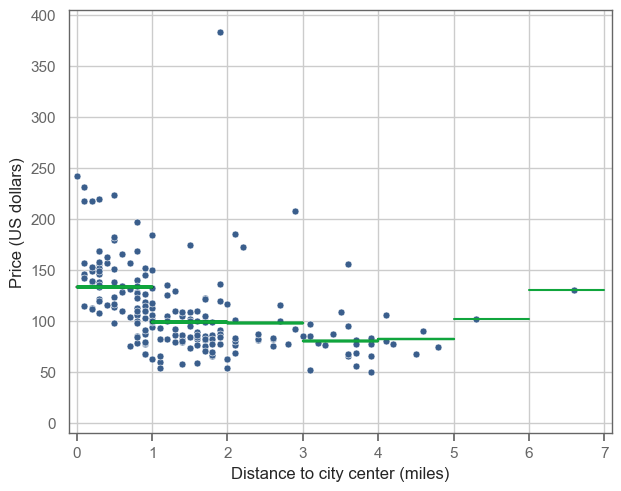

In [29]:
sns.scatterplot(
    data=hotels,
    x='distance',
    y='price',
    color=da.color[0],
    alpha=1,
    s=25
)
for _, row in hotels.iterrows():
    plt.plot([row["dist7_s"],row["xend"]],
             [row["yend"],row["yend"]],linewidth = 1.5,color = da.color[1])
# Customize axes
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

# Figure 7.3
### LOWESS NONPARAMETRIC REGRESSION

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


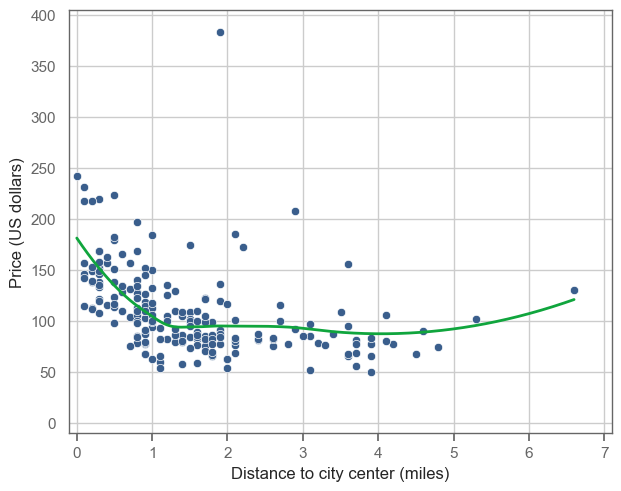

In [30]:
sns.scatterplot(data=hotels, x="distance", y="price")
da.plot_loess(data=hotels,x="distance",y="price",span=0.8,color=da.color[1])
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

In [31]:
### LINEAR REGRESSIONS
regression = smf.ols(formula="price~distance", data=hotels).fit()
regression.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Thu, 01 May 2025   Prob (F-statistic):           3.39e-09
Time:                        11:10:38   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Figure 7.5
### SCATTERPLOT + REGRESSION LINE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


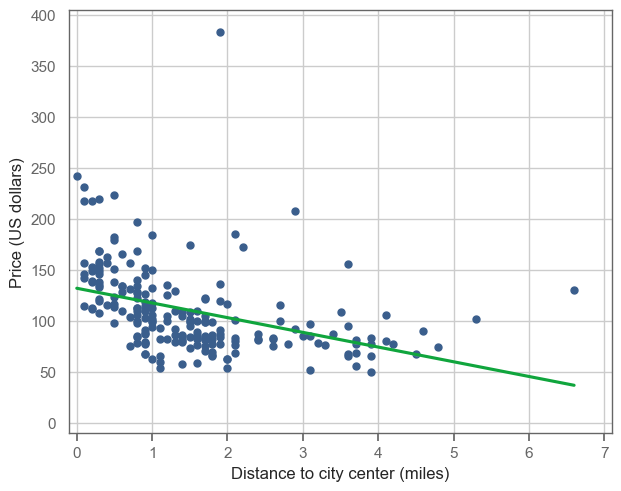

In [32]:
sns.regplot(data=hotels, x="distance", y="price",ci = False,line_kws=dict(color=da.color[1]),scatter_kws=dict(alpha = 1,s = 25))
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

### THE LINEAR REGRESSION GOES THROUGH THE AVERAGES
### SCATTERPLOT + REGRESSION LINE + LINES FOR AVERAGES (NOT in BOOK)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


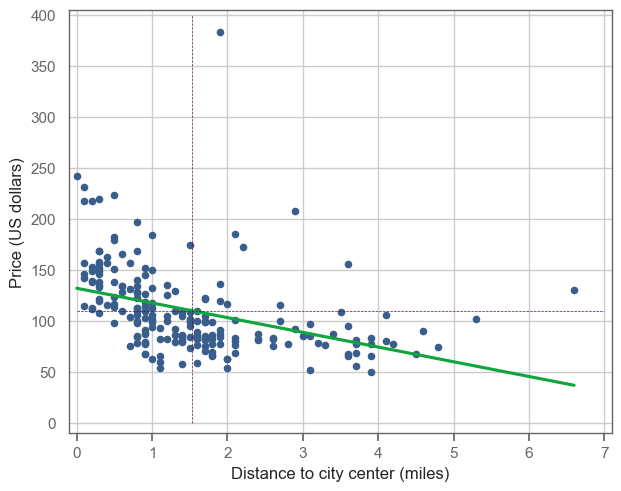

In [33]:
sns.regplot(data=hotels, x="distance", y="price",ci = False,line_kws=dict(color=da.color[1]),scatter_kws=dict(alpha = 1,s = 20))
plt.plot([hotels["distance"].mean(),hotels["distance"].mean()],
             [0,400],linewidth = 0.5,color = da.color[2],linestyle = 'dashed')

plt.plot([0,7],
             [hotels["price"].mean(),hotels["price"].mean()],linewidth = 0.5,color = da.color[2],linestyle = 'dashed')
plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))  
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))  

plt.legend().remove()


plt.show()

### PREDICTED VALUES & RESIDUALS OF LINEAR REGRESSION 

In [34]:
regression = smf.ols(formula="price~distance", data=hotels).fit()


In [35]:
hotels["predprice"] = regression.predict()
hotels["e"] = regression.resid

### Figure 7.6, Table 7.1

Pick one observation, with distance = 2.9, and label the residual on the scatter plot

In [36]:
xa = 2.9 # distance

get annotation values from the dataframe

In [37]:
ya = hotels.loc[hotels["distance"] == xa, "price"].values[0]
ym = hotels.loc[hotels["distance"] == xa, "predprice"].values[0]

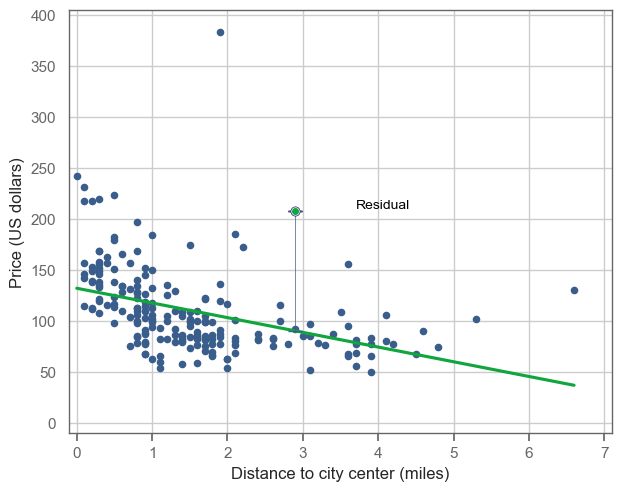

In [38]:
sns.regplot(
    data=hotels,
    x="distance",
    y="price",
    ci=False,
    line_kws=dict(color=da.color[1]),
    scatter_kws=dict(alpha=1, s=20),
)

plt.text(x=3.7, y=210, s="Residual", fontsize=10, color="black")

plt.errorbar(
    x=xa, y=ya, yerr=0, fmt="o", color=da.color[2], capsize=5, label="Pointrange"
)
sns.scatterplot(x=[xa], y=[ya], color=da.color[1], s=30, zorder=3)

subset = hotels.loc[hotels["distance"].round(1) == xa]
if not subset.empty:
    plt.errorbar(
        x=subset["distance"].values[0],
        y=ya,
        yerr=[[ya - ym], [0]],
        fmt="o",
        color=da.color[0],
        capsize=5,
        linewidth=0.5,
    )

plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))

plt.legend().remove()


plt.show()

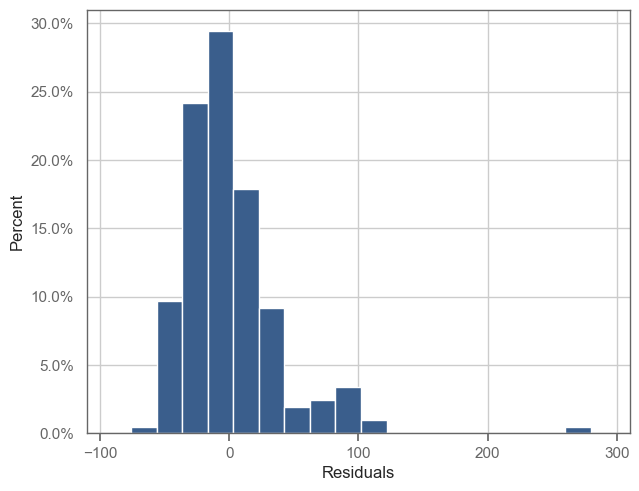

In [39]:
sns.histplot(
    data=hotels,
    x="e",
    binwidth=20,  
    binrange=(-76,280),
    color=da.color[0],
    edgecolor="white",
    stat="probability",  
    alpha=1,
)

plt.xlabel("Residuals")
plt.ylabel("Percent")
plt.ylim(0, 0.31)
plt.yticks(ticks=np.arange(0, 0.31, 0.05))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(-110, 310)
plt.xticks(ticks=np.arange(-100, 301, 100))  
plt.show()

In [40]:
hotels["reg1_res"] = ["overpriced" if e >= 0 else "underpriced" for e in hotels["e"]]


In [41]:
hotels.loc[hotels["e"].sort_values().tail().index, "reg1_res"] = "top5"
hotels.loc[hotels["e"].sort_values().head().index, "reg1_res"] = "bottom5"


In [42]:
bestdeals = hotels.loc[hotels["e"].sort_values().head().index]

### Figure 7.7
### adding annotation

In [43]:
hotels.loc[hotels["reg1_res"] == "bottom5"][["distance","price"]]

,distance,price
10,1.1,60
153,1.1,54
163,0.9,68
211,1.0,63
426,1.4,58


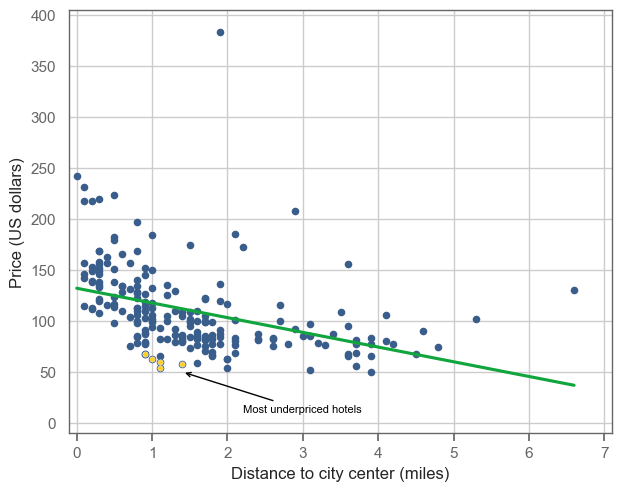

In [44]:
sns.regplot(
    data=hotels,
    x="distance",
    y="price",
    ci=False,
    line_kws=dict(color=da.color[1]),
    scatter_kws=dict(alpha=1, s=20),
)

plt.annotate(
    "Most underpriced hotels",
    xy=(1.4, 50),
    xytext=(2.2, 10),
    arrowprops=dict(color="black", arrowstyle="->"),
    fontsize=8,
)

sns.scatterplot(
    hotels.loc[hotels["reg1_res"] == "bottom5"],
    x="distance",
    y="price",
    color=da.color[3],
    s=15,
    zorder=3,
)


plt.xlabel("Distance to city center (miles)", fontsize=12)
plt.ylabel("Price (US dollars)", fontsize=12)
plt.xlim(-0.1, 7.1)
plt.xticks(np.arange(0, 8, 1))
plt.ylim(-10, 405)
plt.yticks(np.arange(0, 401, 50))
plt.show()

### Table 7.1

In [45]:
(
    hotels.loc[
        hotels["reg1_res"] == "bottom5",
        ["hotel_id", "distance", "price", "predprice", "e"],
    ]
    .sort_values(by=["e"])
    .round(2)
    .reset_index(drop=True)
    .rename({"e": "residual"}, axis=1)
)

,hotel_id,distance,price,predprice,residual
0,22080,1.1,54,116.17,-62.17
1,21912,1.1,60,116.17,-56.17
2,22152,1.0,63,117.61,-54.61
3,22408,1.4,58,111.85,-53.85
4,22090,0.9,68,119.05,-51.05
